In [10]:
import pandas as pd
import os

# Establecer la carpeta de trabajo
#os.chdir("/Users/bautistagoulu/Desktop/Big Data")
os.chdir("/Users/bautistagoulu/Desktop/Big Data")
# Cargar la base de datos
df = pd.read_excel("respondieron2.xlsx")

# Verificar que se cargó bien
df.head()


,CODUSU,ANO4,TRIMESTRE,NRO_HOGAR,COMPONENTE,H15,REGION,MAS_500,AGLOMERADO,PONDERA,...,dummy_tercero,dummy_cuarto,dummy_quinto,dummy_sexto,dummy_septimo,dummy_octavo,dummy_noveno,dummy_educacion_especial,dummy_ns_nr_ch14,PEA
0,TQRMNOSYUHKNKMCDEIGED00856897,2024,1,1,1,1,43,N,30,159,...,0,0,0,0,0,0,0,0,0,1
1,TQRMNOSYUHKNKMCDEIGED00856897,2024,1,1,2,1,43,N,30,159,...,0,0,0,0,0,0,0,0,0,1
2,TQRMNORTVHLOKQCDEIMBF00855868,2024,1,1,1,1,43,N,36,138,...,0,0,0,0,0,0,0,0,0,0
3,TQRMNORTVHLOKQCDEIMBF00855868,2024,1,1,2,1,43,N,36,138,...,1,0,0,0,0,0,0,0,0,1
4,TQRMNORSXHMLLOCDEIMBF00802814,2024,1,1,1,1,43,N,36,149,...,0,0,0,0,0,0,0,0,0,0


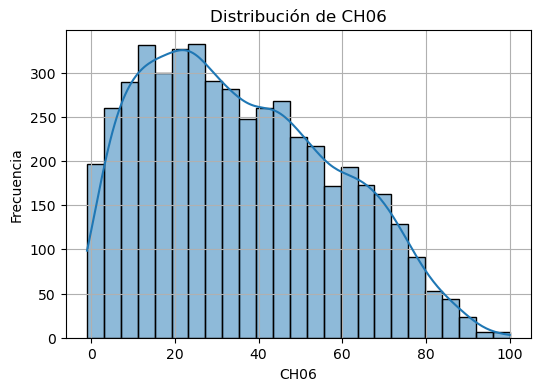

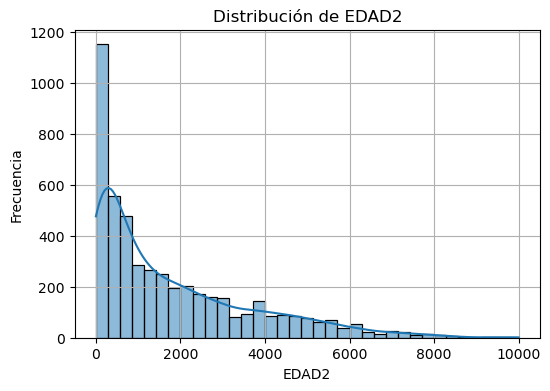

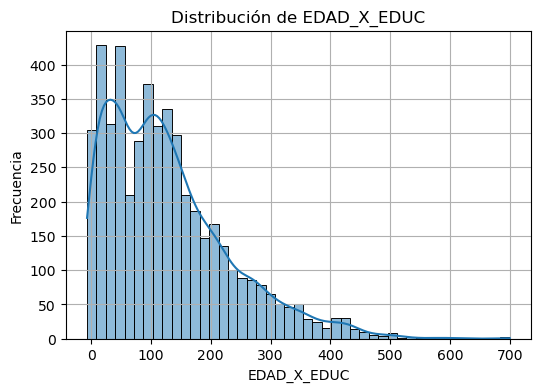

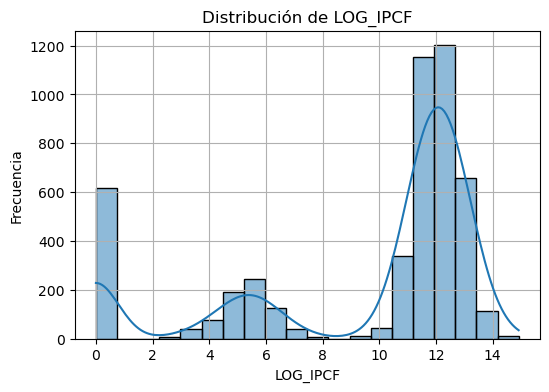

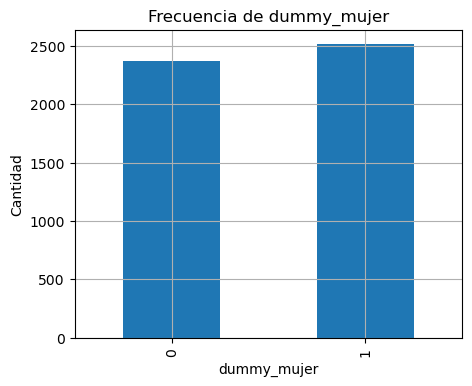

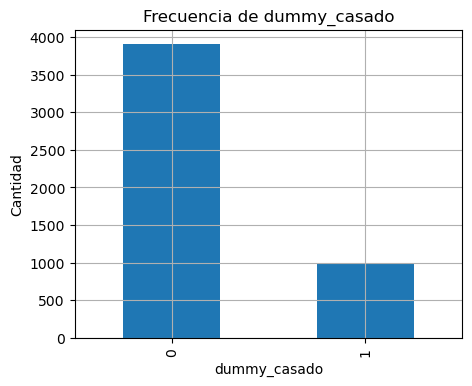

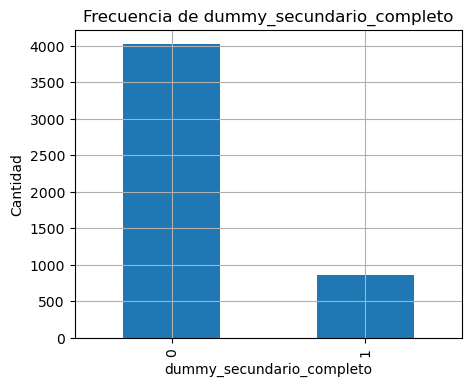

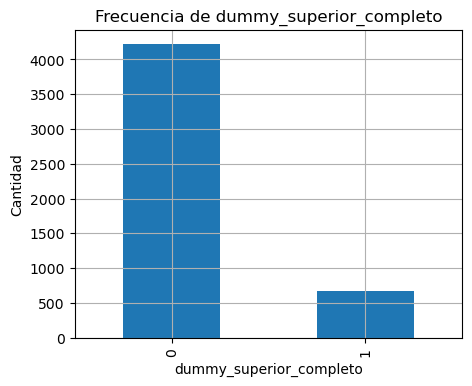

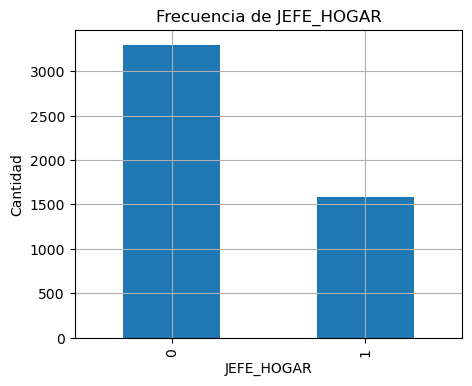

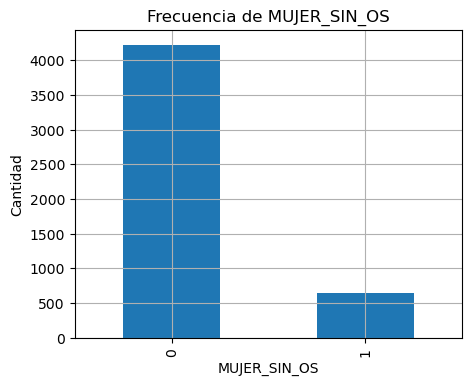

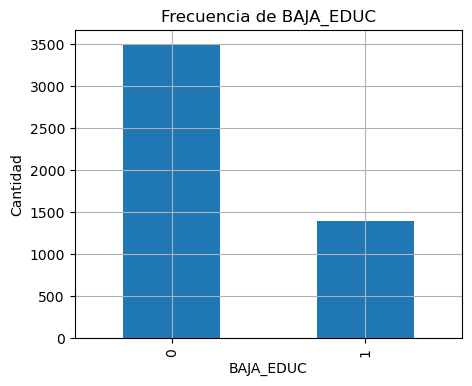

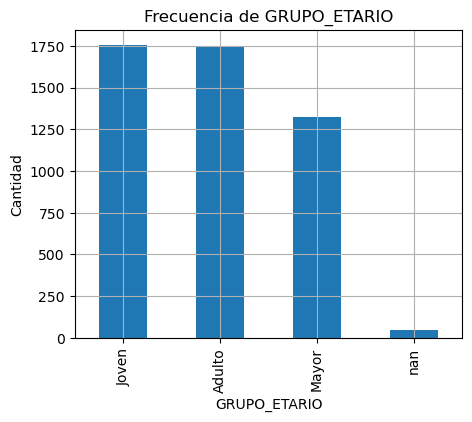

In [14]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar la base original (respondieron2.xlsx)
df = pd.read_excel("respondieron2.xlsx")

# =============================
# VARIABLES SELECCIONADAS Y CREADAS
# =============================

# 1. Sexo (dummy mujer)
df["dummy_mujer"] = (df["CH04"] == 2).astype(int)
# ✔️ Las mujeres suelen tener tasas de desocupación más altas por barreras de género.

# 2. Estado civil (dummy casado)
df["dummy_casado"] = (df["CH07"] == 1).astype(int)
# ✔️ Estar casado puede relacionarse con mayor estabilidad laboral (o al menos con más incentivos a participar del mercado laboral).

# 3. Nivel educativo
df["dummy_secundario_completo"] = (df["NIVEL_ED"] == 4).astype(int)
df["dummy_superior_completo"] = (df["NIVEL_ED"] == 6).astype(int)
# ✔️ Las personas con estudios completos tienen más herramientas para insertarse en el mercado laboral.

# 4. Edad al cuadrado
df["EDAD2"] = df["CH06"] ** 2
# ✔️ Captura efectos no lineales de la edad: los más jóvenes o mayores enfrentan barreras específicas.

# 5. Interacción edad × educación
df["EDAD_X_EDUC"] = df["CH06"] * df["NIVEL_ED"]
# ✔️ La educación puede tener impacto distinto según la etapa de vida (edad).

# 6. Logaritmo del ingreso per cápita
df["LOG_IPCF"] = np.log(df["IPCF"] + 1)
# ✔️ Esta transformación reduce la asimetría de la variable de ingreso.

# 7. Jefe de hogar
df["JEFE_HOGAR"] = (df["CH03"] == 1).astype(int)
# ✔️ Ser jefe de hogar puede estar relacionado con la presión a conseguir empleo.

# 8. Mujer sin obra social
df["MUJER_SIN_OS"] = ((df["CH04"] == 2) & (df["CH08"] == 4)).astype(int)
# ✔️ Indica una situación de vulnerabilidad: mujer sin cobertura de salud formal.

# 9. Grupo etario (categórica)
df["GRUPO_ETARIO"] = pd.cut(df["CH06"], bins=[0, 24, 50, 100], labels=["Joven", "Adulto", "Mayor"])
# ✔️ Agrupamos edades por rangos que suelen tener perfiles laborales distintos.

# 10. Baja educación (primaria completa o menos)
df["BAJA_EDUC"] = (df["NIVEL_ED"] <= 2).astype(int)
# ✔️ Personas con menor capital educativo enfrentan mayores riesgos de desocupación.

# =============================
# GRÁFICOS – CONTINUAS
# =============================
continuas = ["CH06", "EDAD2", "EDAD_X_EDUC", "LOG_IPCF"]

for var in continuas:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[var].dropna(), kde=True)
    plt.title(f"Distribución de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.grid()
    plt.show()

# =============================
# GRÁFICOS – CATEGÓRICAS / DUMMIES
# =============================
categ_vars = ["dummy_mujer", "dummy_casado", "dummy_secundario_completo", "dummy_superior_completo",
              "JEFE_HOGAR", "MUJER_SIN_OS", "BAJA_EDUC", "GRUPO_ETARIO"]

for var in categ_vars:
    plt.figure(figsize=(5, 4))
    df[var].value_counts(dropna=False).sort_index().plot(kind='bar')
    plt.title(f"Frecuencia de {var}")
    plt.xlabel(var)
    plt.ylabel("Cantidad")
    plt.grid()
    plt.show()


In [16]:
# Parte B: Enfoque de validación

In [18]:
df["desocupado"] = (df["ESTADO"] == 2).astype(int)
df["desocupado"].value_counts()
df["dummy_mujer"] = (df["CH04"] == 2).astype(int) #dummy que usaremos luego como variable independiente

In [20]:
#Filtramos solo las observaciones del año 2024
df_2024 = df[df["ANO4"] == 2024].copy()

#Elegimos las variables independientes que vamos a usar
variables_X = ["dummy_casado", "dummy_secundario_completo", "dummy_superior_completo","dummy_mujer",]  

# Creamos X (matriz de variables independientes) e y (vector de variable dependiente)
X_2024 = df_2024[variables_X]
y_2024 = df_2024["desocupado"]

# Dividimos en conjunto de entrenamiento (70%) y test (30%) usando semilla 444
X_train_24, X_test_24, y_train_24, y_test_24 = train_test_split(
    X_2024, y_2024, test_size=0.3, random_state=444)

# Agregamos una columna de unos (constante) para permitir que el modelo tenga intercepto
X_train_24 = X_train_24.reset_index(drop=True)
X_train_24.insert(0, "constante", 1)

In [22]:
# Filtramos solo las observaciones del año 2004
df_2004 = df[df["ANO4"] == 2004].copy()

# Usamos las mismas variables independientes que en 2024
variables_X = ["dummy_casado", "dummy_secundario_completo", "dummy_superior_completo", "dummy_mujer"]

# Definimos X (variables independientes) e y (variable dependiente)
X_2004 = df_2004[variables_X]
y_2004 = df_2004["desocupado"]

# Dividimos en conjunto de entrenamiento (70%) y test (30%) usando semilla 444
X_train_04, X_test_04, y_train_04, y_test_04 = train_test_split(
    X_2004, y_2004, test_size=0.3, random_state=444)

# Agregamos una columna de unos (constante) para permitir que el modelo tenga intercepto
X_train_04 = X_train_04.reset_index(drop=True)
X_train_04.insert(0, "constante", 1)


In [24]:
#2.
# Función para calcular la diferencia de medias entre train y test
def diferencia_de_medias(X_train, X_test):

# Calculamos la media de cada variable en train (quitamos constante)
    medias_train = X_train.drop(columns="constante").mean()
    
# Calculamos la media de cada variable en test
    medias_test = X_test.mean()
    
# Calculamos la diferencia
    diferencia = medias_train - medias_test
    
# Armamos la tabla final
    tabla = pd.DataFrame({
        "media_train": medias_train,
        "media_test": medias_test,
        "diferencia": diferencia
    })
    return tabla

# Aplicamos la función para 2024
tabla_dif_2024 = diferencia_de_medias(X_train_24, X_test_24)

# Aplicamos la función para 2004
tabla_dif_2004 = diferencia_de_medias(X_train_04, X_test_04)

# Mostramos resultados
print("Diferencia de medias - Año 2024")
print(tabla_dif_2024)

print("Diferencia de medias - Año 2004")
print(tabla_dif_2004)



Diferencia de medias - Año 2024
                           media_train  media_test  diferencia
dummy_casado                  0.185620    0.168413    0.017208
dummy_secundario_completo     0.183892    0.197421   -0.013529
dummy_superior_completo       0.158659    0.136986    0.021673
dummy_mujer                   0.514345    0.526189   -0.011844
Diferencia de medias - Año 2004
                           media_train  media_test  diferencia
dummy_casado                  0.310345    0.306667    0.003678
dummy_secundario_completo     0.122605    0.093333    0.029272
dummy_superior_completo       0.044061    0.057778   -0.013716
dummy_mujer                   0.501916    0.484444    0.017471


In [26]:
# Parte C: Métodos de Clasificación y Performance

/Users/bautistagoulu/Anaconda/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


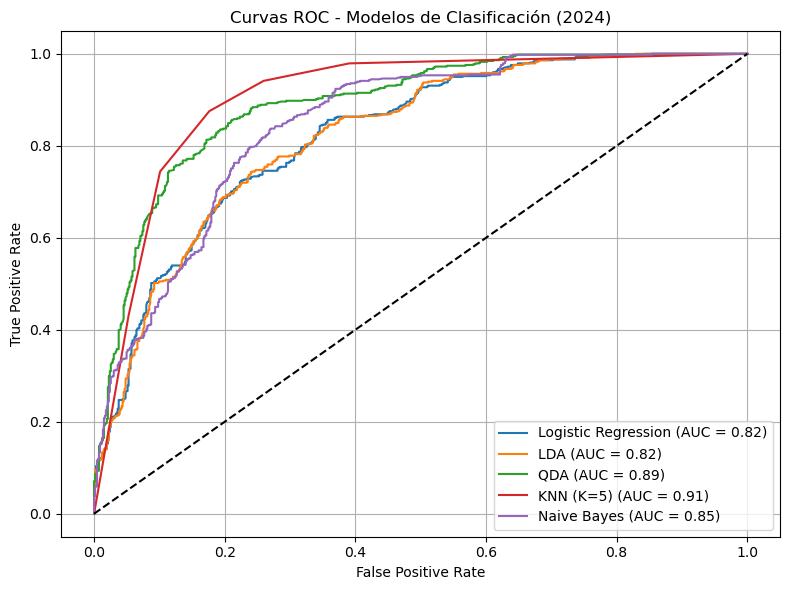

                     Accuracy    AUC
Logistic Regression     0.746  0.824
LDA                     0.750  0.824
QDA                     0.820  0.889
KNN (K=5)               0.848  0.905
Naive Bayes             0.741  0.848


In [61]:
# Volver a cargar dependencias tras el reinicio
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# EMPEZAREMOS POR 2024

# Filtrar por año 2024
df_2024 = df[df["ANO4"] == 2024]

# Selección de variables
features = [
    'CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED',
    'dummy_primario_incompleto', 'dummy_primario_completo',
    'dummy_secundario_incompleto', 'dummy_secundario_completo',
    'dummy_superior_incompleto', 'dummy_superior_completo',
    'dummy_sin_instruccion'
]
X = df_2024[features]
y = df_2024['PEA'].astype(int)

# Split 70/30 con semilla 444
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=444)

# Definir modelos
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "KNN (K=5)": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

# Diccionario para almacenar resultados
resultados = {}

# Ajustar y evaluar cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    conf = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    resultados[nombre] = {
        "Accuracy": acc,
        "AUC": auc,
        "Confusion Matrix": conf,
        "FPR": fpr,
        "TPR": tpr
    }

# Graficar todas las curvas ROC juntas
plt.figure(figsize=(8, 6))
for nombre, res in resultados.items():
    plt.plot(res["FPR"], res["TPR"], label=f"{nombre} (AUC = {res['AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC - Modelos de Clasificación (2024)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear resumen en tabla
tabla_resultados = pd.DataFrame({
    modelo: {
        "Accuracy": datos["Accuracy"],
        "AUC": datos["AUC"]
    } for modelo, datos in resultados.items()
}).T.round(3)
print(tabla_resultados)


/Users/bautistagoulu/Anaconda/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


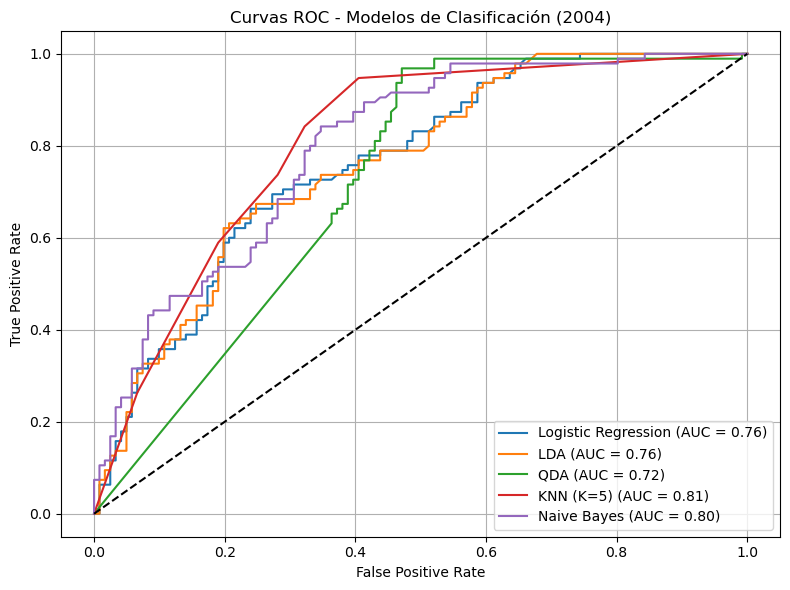

                     Accuracy    AUC
Logistic Regression     0.708  0.763
LDA                     0.694  0.762
QDA                     0.718  0.720
KNN (K=5)               0.727  0.808
Naive Bayes             0.685  0.796


In [65]:
# Filtrar por año 2004
df_2004 = df[df["ANO4"] == 2004]

# Selección de variables
features = [
    'CH04', 'CH06', 'CH07', 'CH08', 'NIVEL_ED',
    'dummy_primario_incompleto', 'dummy_primario_completo',
    'dummy_secundario_incompleto', 'dummy_secundario_completo',
    'dummy_superior_incompleto', 'dummy_superior_completo',
    'dummy_sin_instruccion'
]
X = df_2004[features]
y = df_2004['PEA'].astype(int)

# Eliminar filas con NaNs
X = X.dropna()
y = y.loc[X.index]

# Split 70/30 con semilla 444
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=444)

# Definir modelos
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "KNN (K=5)": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

# Diccionario para almacenar resultados
resultados_2004 = {}

# Ajustar y evaluar cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    conf = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    resultados_2004[nombre] = {
        "Accuracy": acc,
        "AUC": auc,
        "Confusion Matrix": conf,
        "FPR": fpr,
        "TPR": tpr
    }

# Graficar todas las curvas ROC juntas
plt.figure(figsize=(8, 6))
for nombre, res in resultados_2004.items():
    plt.plot(res["FPR"], res["TPR"], label=f"{nombre} (AUC = {res['AUC']:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curvas ROC - Modelos de Clasificación (2004)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Crear resumen en tabla
tabla_resultados_2004 = pd.DataFrame({
    modelo: {
        "Accuracy": datos["Accuracy"],
        "AUC": datos["AUC"]
    } for modelo, datos in resultados_2004.items()
}).T.round(3)

print(tabla_resultados_2004)

